# Part A: Unsupervised Learning
Submitted by : Lim Yuan Her (P7359221)

## 0. Introduction
- The goal is to split the iris dataset observations into well-separated groups assuming no taxonomist is available to label the individual data observations. This is a typical clustering problem and a unsupervised model will be built with the aim of finding the best possible value of k.

## 1. Preparation

### 1.1 Suppress warning messages

In [0]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

### 1.2 Disable auto-scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### 1.3 Load Libraries

In [3]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn
import platform
import math
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Scikit-learn version={}".format(sklearn.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Matplotlib version={}".format(mpl.__version__))
print("Seaborn version={}".format(seaborn.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Scikit-learn version=0.22.1
Numpy version=1.17.5
Pandas version=0.25.3
Matplotlib version=3.1.3
Seaborn version=0.10.0
Python version=3.6.9


In [0]:
from sklearn import datasets 
from sklearn.datasets import load_iris
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 123

## 2. Dataset Loading

In [0]:
iris = load_iris()
X = iris.data

In [6]:
X_df = pd.DataFrame({'Sepal length': X[:, 0], 'Sepal Width': X[:, 1], 'Petal Length': X[:, 2], 'Petal Width': X[:, 3]})
X_df.describe()

,Sepal length,Sepal Width,Petal Length,Petal Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 3. Data Preprocessing

In [0]:
# Load the standard scaler
sc = StandardScaler()

# Compute the mean and standard deviation based on the training data
sc.fit(X)

# Scale the data to be of mean 0 and of unit variance
X_std = sc.transform(X)

## 3. Clustering Evaluation

### 3.1 Evaluate K

#### 3.1.1. Elbow Method

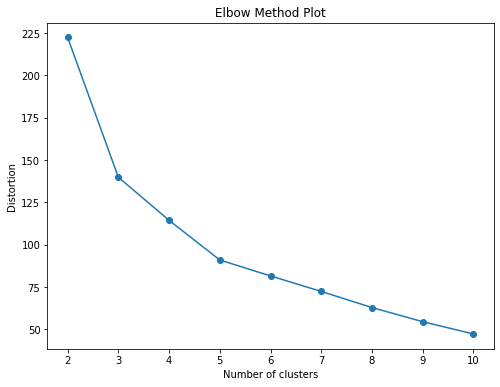

In [8]:
# Elbow Method Plot
from sklearn.cluster import KMeans

distortions = []

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X_std)
    labels = kmeans.labels_
    distortions.append(kmeans.inertia_)
    
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Method Plot")
plt.show()

From the elbow curve above, the number of optimal clusters is 3. Initially, Error measure (within-cluster variance) decreases with increase in cluster number. After k=3 , Error measure starts flattening. Cluster number corresponding to that particular point, k=4, should be considered as optimal number of cluster

#### 3.1.2. Silhouette Score

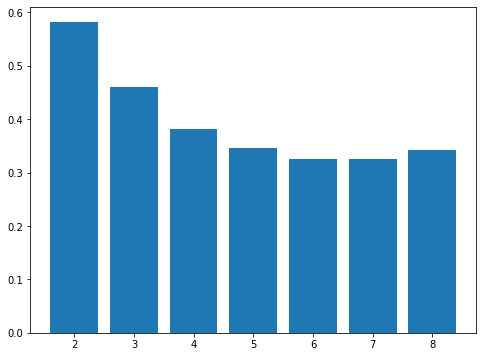

In [9]:
k_scores = {}

for k in range(2,9):
  labels = KMeans(n_clusters=k).fit_predict(X_std)
  k_scores[k] = metrics.silhouette_score(X_std, labels)

plt.figure(figsize=(8,6))
plt.bar(range(len(k_scores)), list(k_scores.values()), align='center')
plt.xticks(range(len(k_scores)), list(k_scores.keys()))
plt.show()

### 3.2 Model Evaluation

In [0]:
nclusters = 3

models_clusterBased = [
    KMeans(n_clusters=nclusters, random_state=seed),
    SpectralClustering(n_clusters=nclusters, random_state=seed),
    MiniBatchKMeans(n_clusters=nclusters, random_state=seed),
    AgglomerativeClustering(n_clusters=nclusters, linkage="ward"),
    AgglomerativeClustering(n_clusters=nclusters, linkage="complete"),
    Birch(n_clusters=nclusters),
    AgglomerativeClustering(n_clusters=nclusters, linkage="average"),
    AgglomerativeClustering(n_clusters=nclusters, linkage="single")
]

names_clusterBased = ['KMeans', 'Spectral Clustering', 'MiniBatch KMeans', 'Ward Hierarchical', 'Complete Hierarchical', 'Birch', 'Average Hierarchical', 'Single Hierarchical']

#### 3.2.1 Scaled Data

##### 3.2.1.1 Evaluation Function

In [0]:
def plotKPlots(plt, X, name, model, nclusters, df):
    # fit a Kmeans model to the data
    model.fit(X)
    label = model.labels_
    sil_coeff = metrics.silhouette_score(X, label, metric='euclidean')
    calharb_score = metrics.calinski_harabasz_score(X, label)
    davbould_score = metrics.davies_bouldin_score(X, label)

    # scatter plot the petal length (column 2), petal width (column 3)
    colors = np.array(["red", "blue", "yellow", "green", "magenta"])
    plt.scatter(X[:, 2], X[:, 3], c=colors[label], s=30, cmap='viridis')
    plt.title('Name = %s, \nSilhouette Coefficient = %.03f, \nCalinski-Harabasz Index = %.03f, \nDavies-Bouldin Index = %.03f' % (name, sil_coeff, calharb_score, davbould_score))

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    return df.append({'Name': name, 'NumClusters': nclusters, 'SilhouetteScore': sil_coeff, 'CalinskiHarabaszScore': calharb_score, 'DaviesBouldinScore': davbould_score}, ignore_index=True)


#### 3.2.1.2 Evaluate Models

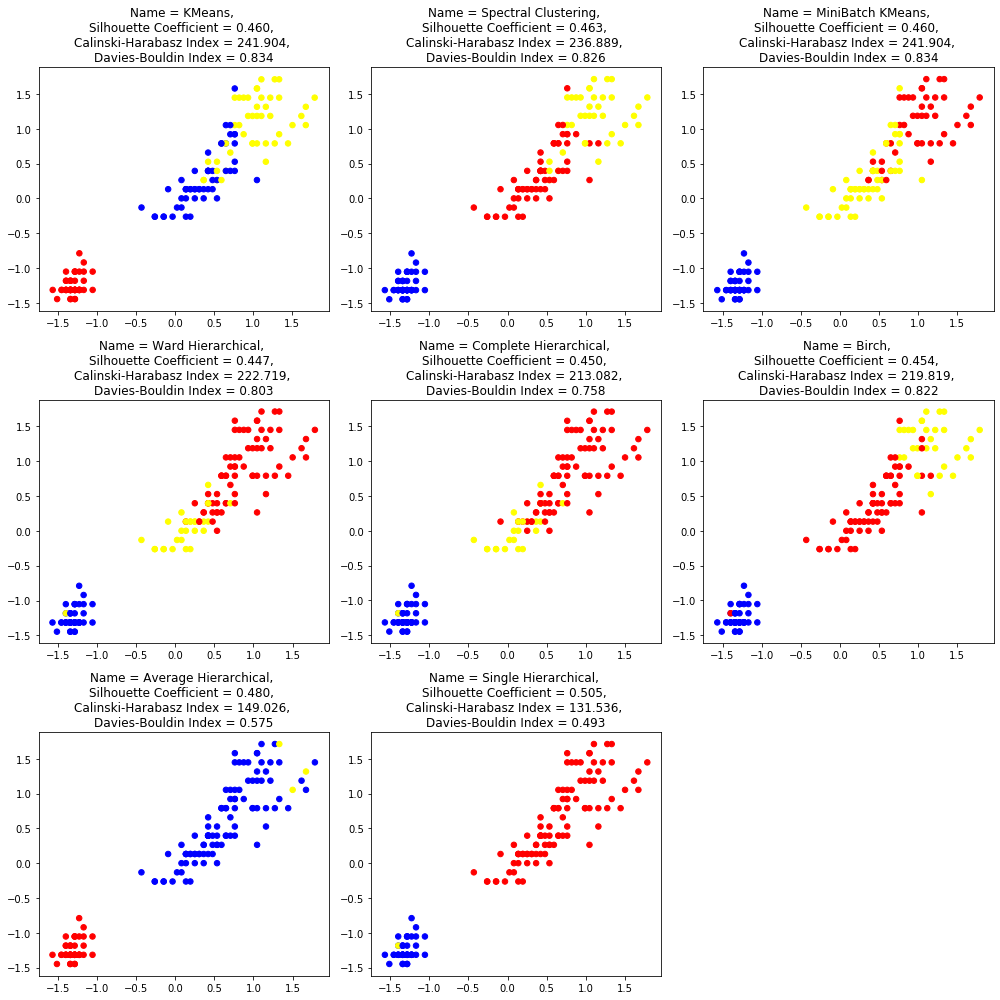

In [12]:
df_Scaled = pd.DataFrame(columns=['Name', 'NumClusters', 'SilhouetteScore', 'CalinskiHarabaszScore', 'DaviesBouldinScore'])

for idx, model in enumerate(models_clusterBased):
    plt.rcParams["figure.figsize"] = (14,14)
    plt.subplot(3, 3, idx + 1)
    df_Scaled = plotKPlots(plt, X_std, names_clusterBased[idx], model, nclusters, df_Scaled)

plt.tight_layout()

In [13]:
# Derive aggregated score based on Silhouette, Calinski Harabasz, and Davies Bouldin scores
df_Scaled['Score'] = df_Scaled['SilhouetteScore'] * df_Scaled['CalinskiHarabaszScore'] * df_Scaled['DaviesBouldinScore']

# Sort results dataframe by 'Score' column in descending order
df_Scaled.sort_values(['Score'], ascending=[False], inplace=True)

df_Scaled

,Name,NumClusters,SilhouetteScore,CalinskiHarabaszScore,DaviesBouldinScore,Score
0,KMeans,3,0.459948,241.904402,0.833595,92.748694
2,MiniBatch KMeans,3,0.459948,241.904402,0.833595,92.748694
1,Spectral Clustering,3,0.462976,236.888875,0.825716,90.559533
5,Birch,3,0.453550,219.818769,0.821830,81.935524
3,Ward Hierarchical,3,0.446689,222.719164,0.803467,79.933840
4,Complete Hierarchical,3,0.449618,213.081710,0.758358,72.654880
6,Average Hierarchical,3,0.480267,149.025799,0.575269,41.173226
7,Single Hierarchical,3,0.504646,131.535896,0.492925,32.719890


#### 3.2.2 PCA

##### 3.2.2.1 Evaluation Function

In [0]:
def plotData(df, groupby, name, fig, idx, model, df_metric):
    #make a scatterplot of the first two principal components of the data, colored by the groupby field
    ax = fig.add_subplot(331 + idx)

    # color map
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
    n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
    cmap_name = 'my_list'

    #cmap = mpl.cm.get_cmap('tab10')
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)

    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size

        label = model.labels_
        sil_coeff = metrics.silhouette_score(X, label, metric='euclidean')
        calharb_score = metrics.calinski_harabasz_score(X, label)
        davbould_score = metrics.davies_bouldin_score(X, label)

    ax.set_title('Name = %s, \nSilhouette Coefficient = %.03f, \nCalinski-Harabasz Index = %.03f, \nDavies-Bouldin Index = %.03f' % (name, sil_coeff, calharb_score, davbould_score))

    return df_metric.append({'Name': name + '_PCA', 'NumClusters': nclusters, 'SilhouetteScore': sil_coeff, 'CalinskiHarabaszScore': calharb_score, 'DaviesBouldinScore': davbould_score}, ignore_index=True)

#### 3.2.2.2 Evaluate Models

In [0]:
ndimensions = 2

pca = PCA(n_components=ndimensions, random_state=seed)
pca.fit(X_std)
X_pca_array = pca.transform(X_std)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component

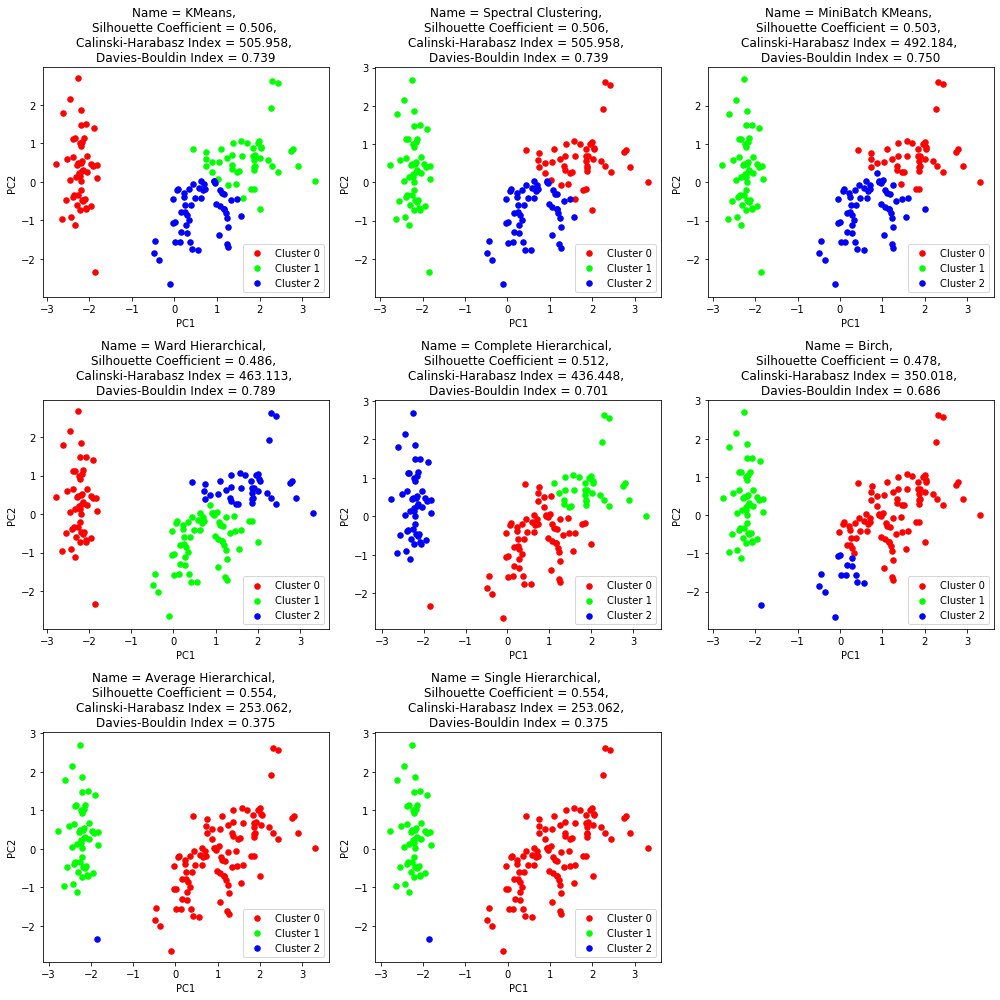

In [16]:
df_PCA = pd.DataFrame(columns=['Name', 'NumClusters', 'SilhouetteScore', 'CalinskiHarabaszScore', 'DaviesBouldinScore'])

fig = plt.figure(figsize=(14, 14))

for idx, model in enumerate(models_clusterBased):
  X_pca['Cluster'] = model.fit_predict(X_pca_array)

  df_PCA = plotData(X_pca, 'Cluster', names_clusterBased[idx], fig, idx, model, df_PCA)

  X_pca.drop('Cluster', 1)

plt.tight_layout()

In [17]:
# Derive aggregated score based on Silhouette, Calinski Harabasz, and Davies Bouldin scores
df_PCA['Score'] = df_PCA['SilhouetteScore'] * df_PCA['CalinskiHarabaszScore'] * df_PCA['DaviesBouldinScore']

# Sort results dataframe by 'Score' column in descending order
df_PCA.sort_values(['Score'], ascending=[False], inplace=True)

df_PCA

,Name,NumClusters,SilhouetteScore,CalinskiHarabaszScore,DaviesBouldinScore,Score
0,KMeans_PCA,3,0.506153,505.957631,0.738682,189.170470
1,Spectral Clustering_PCA,3,0.506153,505.957631,0.738682,189.170470
2,MiniBatch KMeans_PCA,3,0.503489,492.184439,0.750328,185.938119
3,Ward Hierarchical_PCA,3,0.485768,463.112725,0.788649,177.418550
4,Complete Hierarchical_PCA,3,0.511822,436.447626,0.701087,156.611211
5,Birch_PCA,3,0.478296,350.017579,0.685556,114.770305
6,Average Hierarchical_PCA,3,0.553808,253.061764,0.374795,52.526551
7,Single Hierarchical_PCA,3,0.553808,253.061764,0.374795,52.526551


#### 3.2.3 Comparison

In [18]:
df = pd.concat([df_Scaled, df_PCA])

# Derive aggregated score based on Silhouette, Calinski Harabasz, and Davies Bouldin scores
df['Score'] = df['SilhouetteScore'] * df['CalinskiHarabaszScore'] * df['DaviesBouldinScore']

# Sort results dataframe by 'Score' column in descending order
df.sort_values(['Score'], ascending=[False], inplace=True)

df.head(3)

,Name,NumClusters,SilhouetteScore,CalinskiHarabaszScore,DaviesBouldinScore,Score
0,KMeans_PCA,3,0.506153,505.957631,0.738682,189.170470
1,Spectral Clustering_PCA,3,0.506153,505.957631,0.738682,189.170470
2,MiniBatch KMeans_PCA,3,0.503489,492.184439,0.750328,185.938119


##### 3.2.3.1 Compare Silhouette Samples

In [0]:
def plotSilhouetteProfile(name, model, X):
  y_kmeans = model.fit_predict(X)
  scores = metrics.silhouette_samples(X, y_kmeans)

  df_scores = pd.DataFrame()
  df_scores['SilhouetteScore'] = scores
  df_scores['Cluster'] = y_kmeans

  plt.rcParams["figure.figsize"] = (8,4)

  for i, cluster in df_scores.groupby('Cluster'):
    plt.subplot(1,3,i+1)
    plt.hist(cluster['SilhouetteScore'], range=(0,1.0), bins=20)
  plt.suptitle(name)
  plt.show()

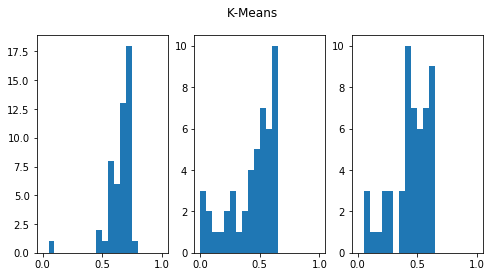

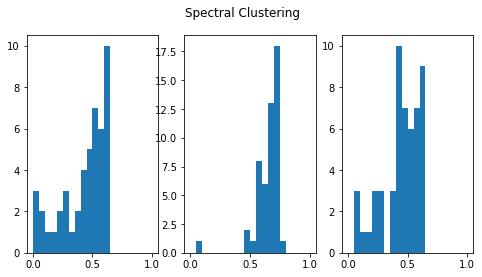

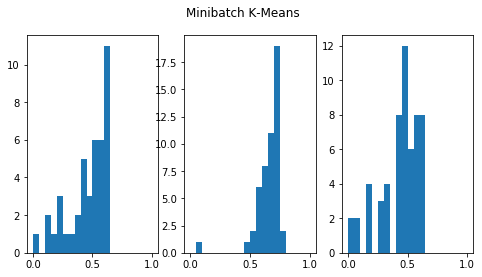

In [44]:
models =  {
            "K-Means": KMeans(n_clusters=nclusters, random_state=seed),
            "Spectral Clustering": SpectralClustering(n_clusters=nclusters, random_state=seed),
            "Minibatch K-Means": MiniBatchKMeans(n_clusters=nclusters, random_state=seed)
          }

for name, model in models.items():
  plotSilhouetteProfile(name, model, X_pca_array)

## 4. Conclusion

Based on the aggregated score, it can be concluded that K-Means and Spectral Clustering provides the optimal results with clear delineation of the different clusters identified.

## 5. References

- [Scikit-Learn - Clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
- [Clustering Evaluation strategies](https://towardsdatascience.com/clustering-evaluation-strategies-98a4006fcfc)